# Assignment 3: Implementation, Analysis, Performance Evaluation and Comparison of Deep Convolutional Neural Networks for Image Classification

**Objective:** The objective of this assignment is to implement a deep convolutional neural network (CNN) for the identification of flower types. The provided dataset consists of five classes of flowers, namely chamomile, tulip, rose, sunflower, and dandelion.

**Tasks:**
To complete this assignment, please submit a single notebook that includes the implementation and outputs of the following seven steps.
Provide answers for each sub-question by thorough analysis and extensive experimental investigation using the provided dataset. In other words, your answers should be backed by experimental analysis of your models and the dataset. Please ensure that the notebook retain the outputs. Failure to do so will result in zero marks for the corresponding steps in which no output is displayed.

In [ ]:
%ls

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/MyDrive/Colab Notebooks/ai/assignment3

In [ ]:
%cd taken_imgs


In [ ]:
%cd ..

**1. Prepare and Preprocess the data. (15 points)**

**Q1.1. What is the total number of images in the dataset, and how are they distributed across the five flower types?**
* The dataset consists of a total of 4,357 images distributed across five types of flowers:
- **Daisy**: 764 images
- **Dandelion**: 1,054 images
- **Rose**: 784 images
- **Sunflower**: 733 images
- **Tulip**: 984 images

**Q1.2. Do we need to implement techniques to balance the distribution of images across various flower types, such as oversampling or undersampling?**

&nbsp;&nbsp;&nbsp;&nbsp;According to the distribution of flower types, there is not much difference among these types. I don’t think we need to implement techniques such as oversampling or undersampling.

**Q1.3. What are the dimensions (height and width) of the images in the dataset, and is there any variation among different flower types?**

&nbsp;&nbsp;&nbsp;&nbsp;According to the Flower Dimensions:
- The dimensions of the images in the dataset range from around 50px to over 1000px, which is not uniform.
- Yes, there is a high degree of variance in the image dimensions.

**Q1.4. What preprocessing techniques should be applied, such as resizing, normalization or standardization and why?**

&nbsp;&nbsp;&nbsp;&nbsp;Because images are not the same size, resizing should be applied. Other preprocessing techniques such as normalization or standardization should also be considered because they might help stabilize the training process and improve inference performance. However, I will not apply these techniques for the first model.

**Q1.5. How would you split the dataset into training, validation and testing sets, and in what ratios?**

&nbsp;&nbsp;&nbsp;&nbsp;I split the dataset into training, validation, and testing sets in a ratio of 80/10/10 respectively using the `splitfolders` module.



In [16]:
import os
import glob
import random
import pickle
import zipfile
import splitfolders
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import DenseNet121, InceptionV3, MobileNetV3Large, ResNet50, MobileNetV2, VGG16

# Data exploration

In [ ]:
# unzip the flowers dataset
folder_dir = './flowers.zip'
zip_ref = zipfile.ZipFile(folder_dir, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [ ]:
# split dataset to 80/10/10
root_dir = './flowers'
out_dir = './flowers_split'
splitfolders.ratio(root_dir, output=out_dir, seed=1337, ratio=(.8, .1, .1))

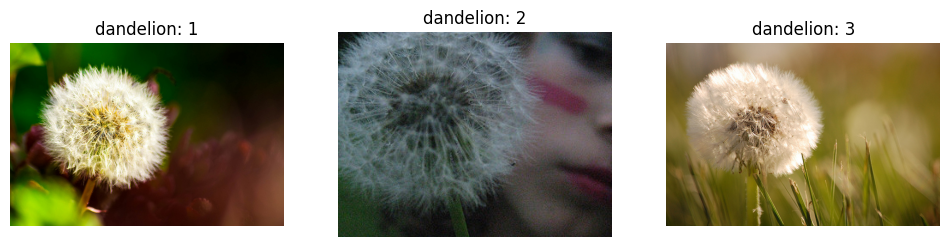

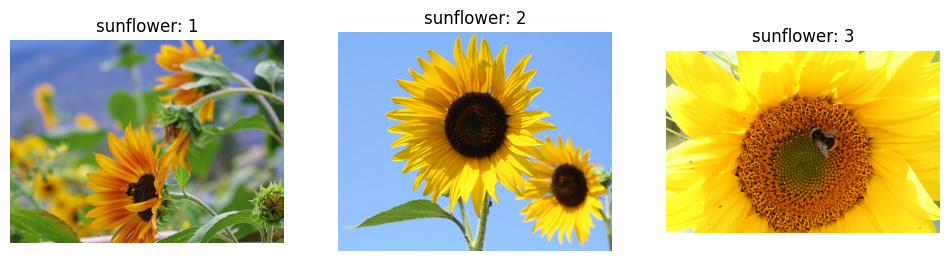

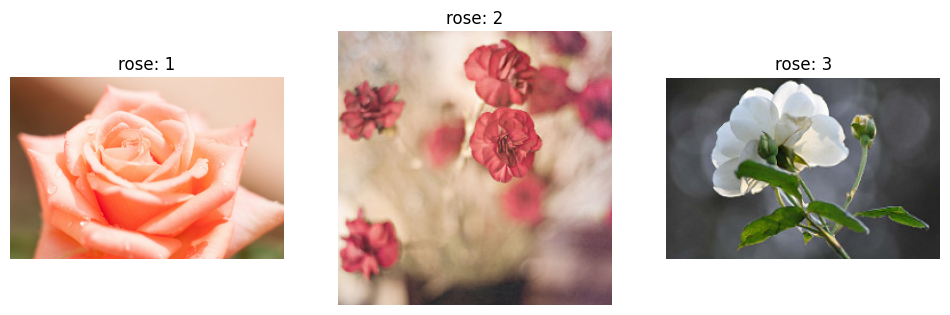

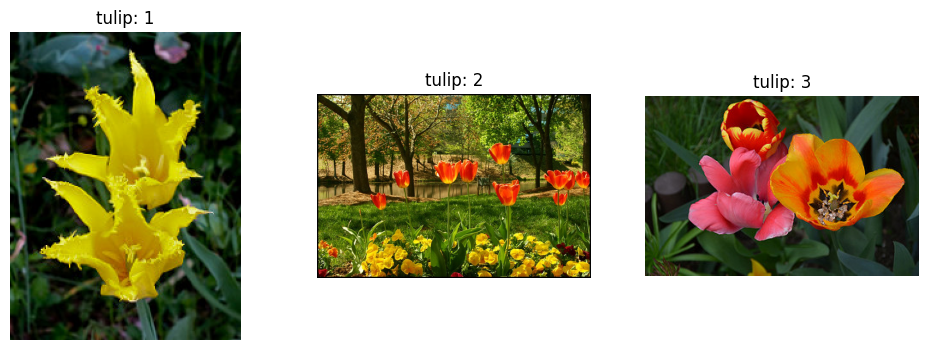

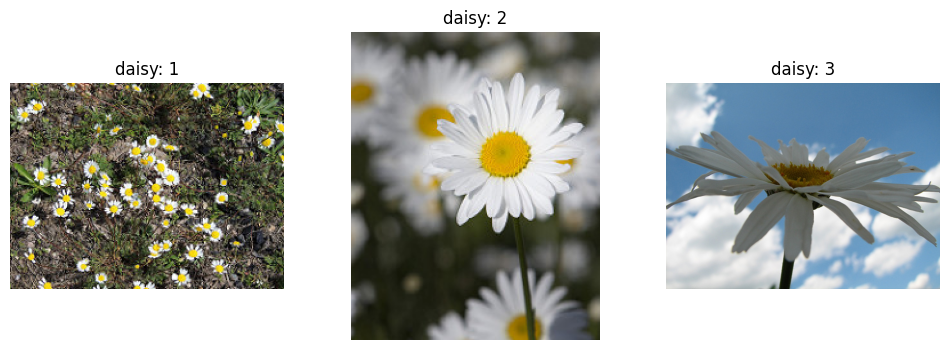

Total number of Daisy images: 764
Total number of Dandelion images: 764
Total number of Rose images: 784
Total number of Sunflower images: 733
Total number of Tulip images: 984
Total number of images: 4317


In [ ]:
# Exploring dataset
unsplit_data_dir = './flowers'

daisy_nums = 0
dandelion_nums = 0
rose_nums = 0
sunflower_nums = 0
tulip_nums = 0

daisy_dims = []
dandelion_dims = []
rose_dims = []
sunflower_dims = []
tulip_dims = []

for type_flower_dir in os.listdir(unsplit_data_dir):
    image_names = os.listdir(os.path.join(unsplit_data_dir, type_flower_dir))

    for image_name in image_names:
        image_path = os.path.join(unsplit_data_dir, type_flower_dir, image_name)
        img = mpimg.imread(image_path)
        if type_flower_dir == 'daisy':
            daisy_dims.append(img.shape)
        elif type_flower_dir == 'dandelion':
            dandelion_dims.append(img.shape)
        elif type_flower_dir == 'rose':
            rose_dims.append(img.shape)
        elif type_flower_dir == 'sunflower':
            sunflower_dims.append(img.shape)
        elif type_flower_dir == 'tulip':
            tulip_dims.append(img.shape)

    if type_flower_dir == 'daisy':
        daisy_nums = len(image_names)
    elif type_flower_dir == 'dandelion':
        dandelion_nums = len(image_names)
    elif type_flower_dir == 'rose':
        rose_nums = len(image_names)
    elif type_flower_dir == 'sunflower':
        sunflower_nums = len(image_names)
    elif type_flower_dir == 'tulip':
        tulip_nums = len(image_names)



    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    sample_image_names = image_names[:3]
    for i, image_name in enumerate(sample_image_names):
        image_path = os.path.join(unsplit_data_dir, type_flower_dir, image_name)
        img = mpimg.imread(image_path)
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f'{type_flower_dir}: {i+1}')

    plt.show()


print(f'Total number of Daisy images: {daisy_nums}')
print(f'Total number of Dandelion images: {daisy_nums}')
print(f'Total number of Rose images: {rose_nums}')
print(f'Total number of Sunflower images: {sunflower_nums}')
print(f'Total number of Tulip images: {tulip_nums}')
print(f'Total number of images: {daisy_nums + dandelion_nums + rose_nums + sunflower_nums + tulip_nums}')


In [2]:
# Flower types
flower_types = ['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip']

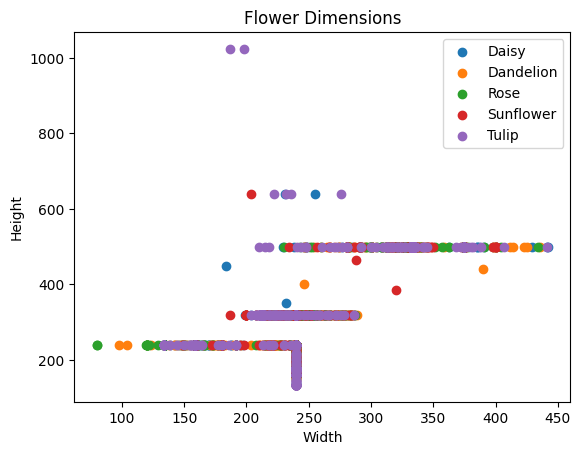

In [ ]:
# Dimensions
flower_dims = [daisy_dims, dandelion_dims, rose_dims, sunflower_dims, tulip_dims]

# Plot scatter of flower_dims
for i, dim in enumerate(flower_dims):
    x = [d[0] for d in dim]
    y = [d[1] for d in dim]
    plt.scatter(x, y, label=flower_types[i])

plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Flower Dimensions')
plt.legend()
plt.show()

Dimensions of images are not consistent, need to be resized

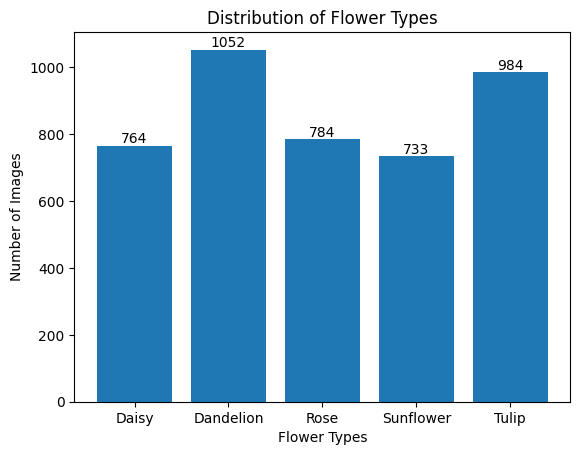

In [ ]:
flower_nums = [daisy_nums, dandelion_nums, rose_nums, sunflower_nums, tulip_nums]

plt.bar(flower_types, flower_nums)
plt.xlabel('Flower Types')
plt.ylabel('Number of Images')
plt.title('Distribution of Flower Types')

# Add number on top of the bars
for i, num in enumerate(flower_nums):
    plt.text(i, num, str(num), ha='center', va='bottom')

plt.show()


# Preprocessing data

In [3]:
train_dir = './flowers_split/train'
val_dir = './flowers_split/val'
test_dir = './flowers_split/test'

img_height = 224
img_width = 224
batch = 64


train_gen = ImageDataGenerator(
      rescale=1./255)

val_datagen = ImageDataGenerator(
      rescale=1./255)

test_datagen = ImageDataGenerator(
      rescale=1./255)

train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch,
    class_mode='sparse',
    shuffle = True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch,
    class_mode='sparse',
    shuffle = False)

classes = list(val_generator.class_indices.keys())

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch,
    class_mode='sparse',
    shuffle = False)


Found 3452 images belonging to 5 classes.
Found 430 images belonging to 5 classes.
Found 435 images belonging to 5 classes.


**2. Implement the given CNN architecture. Make necessary changes in the final layers for it to work on the number of classes in the given dataset. Use an input image size of $224 \times 224 \times 3$ (10 points)**
<img src='CNN.png' alt='given CNN'>

# Base model

In [ ]:
model_base = Sequential(name='model_base')

model_base.add(Conv2D(64, (3,3), activation='relu', input_shape=(img_height, img_width, 3),padding='same',kernel_initializer='he_normal'))
model_base.add(Conv2D(64, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model_base.add(Conv2D(128, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base.add(Conv2D(128, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model_base.add(Conv2D(256, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base.add(Conv2D(256, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base.add(Conv2D(256, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model_base.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model_base.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model_base.add(Flatten())
model_base.add(Dense(4096, activation='relu',kernel_initializer='he_normal'))
model_base.add(Dense(4096, activation='relu',kernel_initializer='he_normal'))
model_base.add(Dense(5, activation='softmax'))

optimizer = Adam(learning_rate = 1e-4)
model_base.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_base.summary()

Model: "model_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

**3. Train the model. (15 Points)**

Q3.1. What is your approach for selecting the appropriate hyperparameters for the model training, such as the learning rate, number of epochs, batch size, and optimizer?
* I started with learning rate = 0.0001, batch size = 64, and optimizer = Adam. After looking at the training process with accuracy and loss, I might have to change those hyperparameters and explain when that happen

Q3.2 What methods do you use for monitoring the training progress and performance of the model and why?
* Accuracy and Loss are two metrics used to evaluate training and evaluating processes. Because by looking at the line of train and validation, we can easily detect overfitting or underfitting

Q3.3 What metrics would you prefer to measure the performance, such as accuracy, precision, recall, F1 score, or ROC-AUC and why?
* Accuracy, precision, recall and F1-score were all used to measure the performance of the testing dataset. I chose that because looking at those metrics might be easier to detect which class the model performed well and poorly and make some adjustment to balance along those all classes.


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_base = model_base.fit(train_generator, epochs=20, validation_data=val_generator, verbose=1, callbacks=[early_stopping])

# Save history
with open('history_base.pkl', 'wb') as file:
    pickle.dump(history_base.history, file)

model_base.save('model_base.h5')


In [ ]:
# Load the model
model_base = load_model('model_base.h5')

# Load the history
with open('history_base.pkl', 'rb') as file:
    history_base = pickle.load(file)


2024-04-14 13:24:18.215887: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 13:24:18.216592: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


**4. Report the results. (10 points)**

Q4.1 What is the final accuracy of the model on the validation set, and how does it compare to the training accuracy?
* Final accuracy on validation dataset is 0.6767 and on training dataset is 0.9802. The base model is overfitting because validation and training accuracy should be closed to each other

Q4.2 What is the confusion matrix for the model on the validation set, and which flower types are the most difficult to classify?
* Confustion matrix for the model is plotted below. By looking at F1-score and the heatmap figure, I found Roses which has the lowest F1-score (0.60) is the flower types make the model confused the most.

Q4.3 How does the model perform on individual flower types, and are there any particular images that the model struggles to classify?
* Roses is the flower types that the model struggles to classify. Also, as can be seen from false images, we can see images that was taken too closed or too far also hard to be classified

Q4.4 What is the rough model complexity?
* Model has total params: 134,281,029 (512.24 MB). It has 13 convolutional layers and 3 Fully connected layers.

Q4.5 Is the model's large size contributing to any challenges or constraints in its performance on the given dataset.
* Yes, the model can be called a large model. The metrics also indicated that, the model was **overfitting**, which means the architecture is too complicated. And also the validation loss and accuracy were **fluctuated**, so we might need to implement technique to mitigate overfitting and unstable performance such as **L2** and **Batch Normalization**

In [ ]:
def plot_history(history):
    """
    Plots the loss and accuracy of the training and validation data
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    # plt.plot(history.history['loss'], label='Training Loss')
    # plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    # plt.plot(history.history['accuracy'], label='Training Accuracy')
    # plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    report = classification_report(y_true, y_pred,target_names = classes, zero_division=0)
    print(report)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap="Blues",xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
def plot_false_predictions(y_true, y_pred, num_imgs):
    false_indices = np.where(y_true != y_pred)[0]
    false_indices = false_indices[:num_imgs]

    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(false_indices):
        plt.subplot(3, 3, i + 1)
        img = mpimg.imread(test_generator.filepaths[idx])
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'True: {classes[int(y_true[idx])]}, Predicted: {classes[int(y_pred[idx])]}')

    plt.tight_layout()
    plt.show()

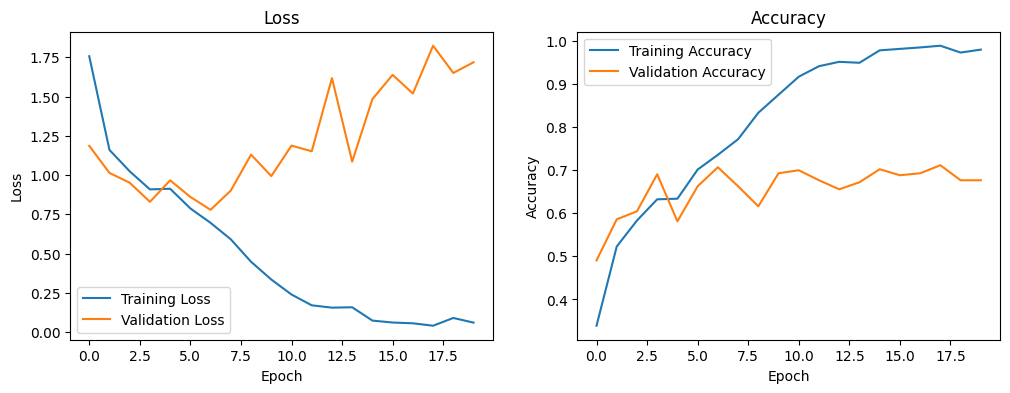

2024-04-14 13:24:39.970592: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 822083584 exceeds 10% of free system memory.
2024-04-14 13:24:40.275158: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 822083584 exceeds 10% of free system memory.


1/7 [===>..........................] - ETA: 1:02

2024-04-14 13:24:49.897077: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 822083584 exceeds 10% of free system memory.
2024-04-14 13:24:50.262138: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 822083584 exceeds 10% of free system memory.


2/7 [=======>......................] - ETA: 50s 

2024-04-14 13:25:00.021262: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 822083584 exceeds 10% of free system memory.


7/7 [==============================] - 70s 10s/step
              precision    recall  f1-score   support

       daisy       0.75      0.58      0.65        76
   dandelion       0.66      0.84      0.74       105
        rose       0.56      0.64      0.60        78
   sunflower       0.84      0.66      0.74        73
       tulip       0.67      0.62      0.65        98

    accuracy                           0.68       430
   macro avg       0.70      0.67      0.67       430
weighted avg       0.69      0.68      0.68       430



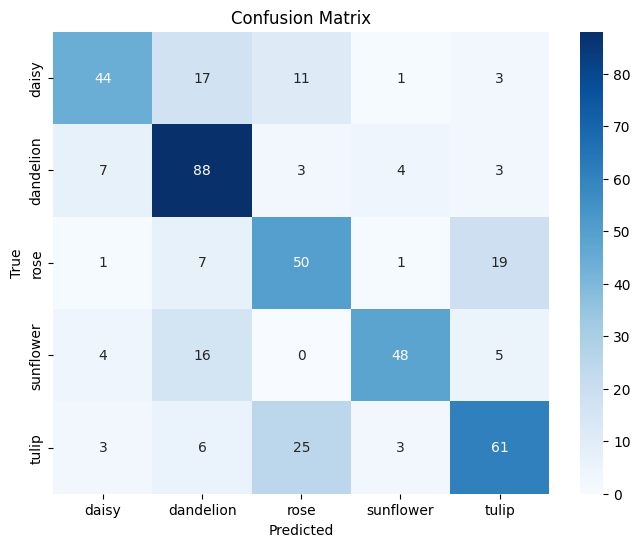

In [ ]:
plot_history(history_base)

y_pred = model_base.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

plot_confusion_matrix(y_true, y_pred)


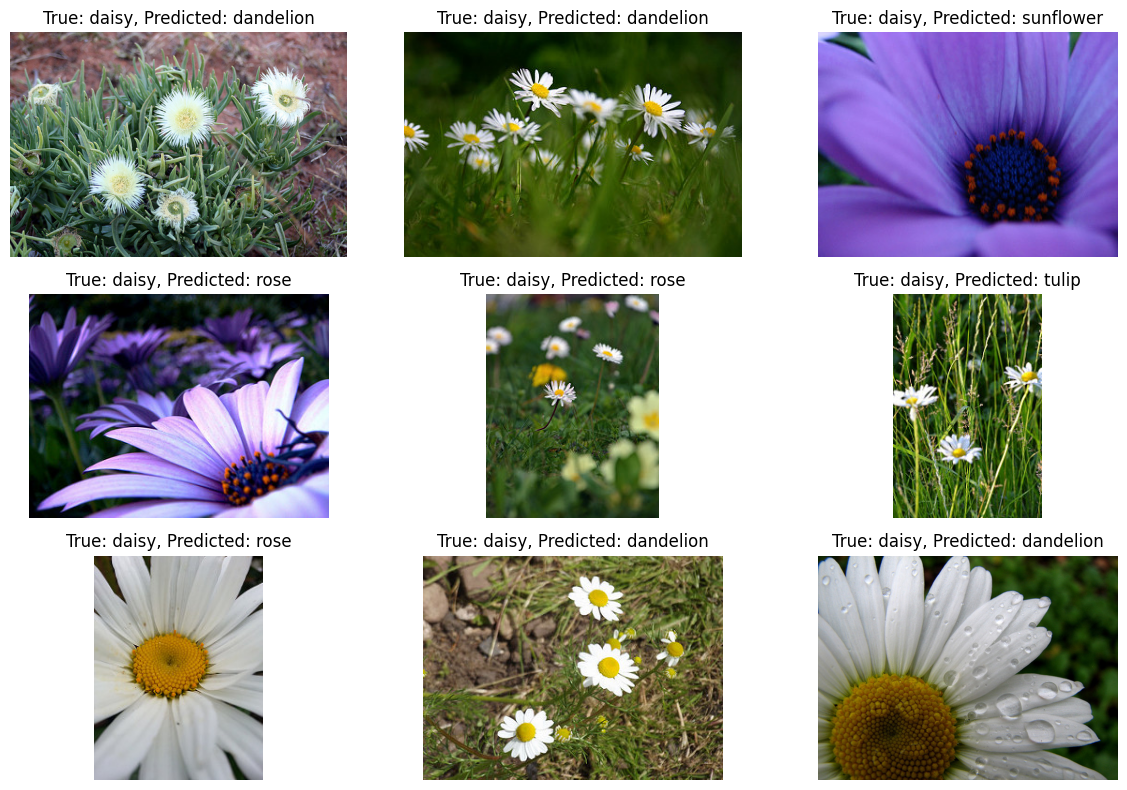

In [ ]:
plot_false_predictions(y_true, y_pred, 9)

* Base model is overfitting and unstable => L2 and BatchNorm
* Model perform poorly on Rose, images taken too close or too far from the flower

**5. Test the model by giving it a picture taken by your own phone camera. (10 points)**

Q5.1 How can the accuracy of the model on the picture taken by your own phone camera be evaluated?
* The accuracy of the model is evaluated by manually compare the actual type of the flower and the model's prediction. The number 78.574 is highest probability in softmax layer. Comparing it to overall accuracy = 0.68 showed that the model is overconfident. Those number should be close to each other, so we could try to implement temperature scaling if needed (Kull et al. 2019, p. 1)

Q5.2 What can be done if the model does not perform well on the picture taken by your own phone camera?
* If the model does not perfor well on the picture taken my camera, it means the model is not generalized enough. It only perform well on train dataset(limited and might not diversed enough) but not really good at real images. That the indication of overfitting, so I will try to implement techniques such as Batch Normalization, Drop out, L2


Found 1 images belonging to 1 classes.
1/1 [==============================] - 1s 592ms/step


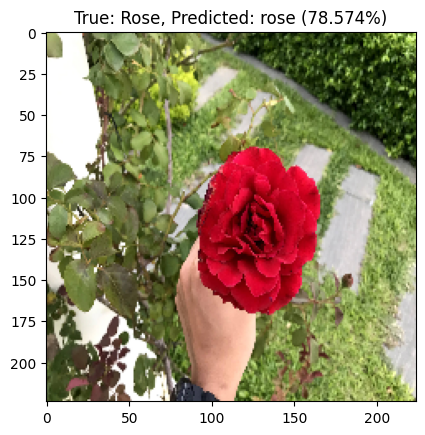

In [ ]:
def test_real_img(model):
    taken_img_dir = "./taken_imgs"

    taken_img_datagen = ImageDataGenerator(
        rescale=1./255)

    taken_img_generator = taken_img_datagen.flow_from_directory(
        taken_img_dir,
        target_size=(img_height,img_width),
        batch_size=batch,
        class_mode=None,
        shuffle=False
    )

    predictions = model.predict(taken_img_generator)
    pred_class = classes[np.argmax(predictions)]

    photo_img_path = glob.glob(taken_img_dir+'/unknown/*')[0]
    confidence_score = predictions[0][np.argmax(predictions[0])]
    img = image.load_img(photo_img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    plt.imshow(img_array/ 255.0)
    plt.title(f"True: Rose, Predicted: {pred_class} ({confidence_score*100:.3f}%)")
    plt.show()
    
test_real_img(model_base)

**6. Use the same architecture but now train two different models one with L1 or L2 regularization, and one with batch normalization. (20 points)**


Q6.1 Based on the results of the regularized and batch normalized models, how effective are L1 or L2 regularization and batch normalization techniques? How do they impact the model's performance, convergence, size, and inference time?
* L2 made the model's performance decreased from 0.67 to 0.60 in macro average F1-score; converged faster by looking at those two accuracy figures; did not change the size; increased to inference time from 70s to 72s; and made the model less overfit
* Batch normalization the model's performance increased from 0.67 to 0.68 in macro average F1-score; converged in the same pace; did not change the size; did not change inference time; and made the model more overfit

Q6.2 How do the learned weights of the L1 or L2 regularized models compare to the baseline model? Provide any insights on the differences in the learned weights and what it implies for the model's performance and interpretability?
* L2 regularization will penalize the large weights, which is used to migigate overfitting. That is exactly what needs to be implemented in the base model. 
As looking at the Comparison of Mean Weights graph, the weight is more stable (also in the loss and accuracy graph). In large architecture as the base model, exploding or vanishing gradients could be problems, so that introducing L2 also prevent those.

Q6.3 What insights can be drawn from the comprehensive analysis of the regularized and batch normalized models regarding the use of regularization and normalization techniques in training machine learning models?
* L2 and Batch normmalization enhanced both generalization and training stability. They improved the base model's macro average F1-score and made the training much more stable. So later in this project, I will integrate both of them and also dropout (to make model simpler) to avoid overfitting and more robust

# Base model with L2


In [ ]:
model_base_l2 = Sequential(name='model_base_l2')
model_base_l2.add(Conv2D(64, (3,3), activation='relu', input_shape=(img_height, img_width, 3),padding='same',kernel_initializer='he_normal'))
model_base_l2.add(Conv2D(64, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_base_l2.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model_base_l2.add(Conv2D(128, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_base_l2.add(Conv2D(128, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_base_l2.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model_base_l2.add(Conv2D(256, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_base_l2.add(Conv2D(256, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_base_l2.add(Conv2D(256, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_base_l2.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model_base_l2.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_base_l2.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_base_l2.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_base_l2.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model_base_l2.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_base_l2.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_base_l2.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_base_l2.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model_base_l2.add(Flatten())
model_base_l2.add(Dense(4096, activation='relu',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_base_l2.add(Dense(4096, activation='relu',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_base_l2.add(Dense(5, activation='softmax'))

optimizer = Adam(learning_rate = 1e-4)
model_base_l2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_base_l2.summary()

Model: "model_base_l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_40 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_42 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 56, 56, 128)       0         
 ng2D)                                               

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_base_l2 = model_base_l2.fit(train_generator, epochs=20, validation_data=val_generator, verbose=1, callbacks=[early_stopping])

# Save history
with open('history_base_l2.pkl', 'wb') as file:
    pickle.dump(history_base_l2.history, file)

# Save model
model_base_l2.save('model_base_l2.h5')

In [ ]:
# Load the model
model_base_l2 = load_model('model_base_l2.h5')

# Load the history
with open('history_base_l2.pkl', 'rb') as file:
    history_base_l2 = pickle.load(file)


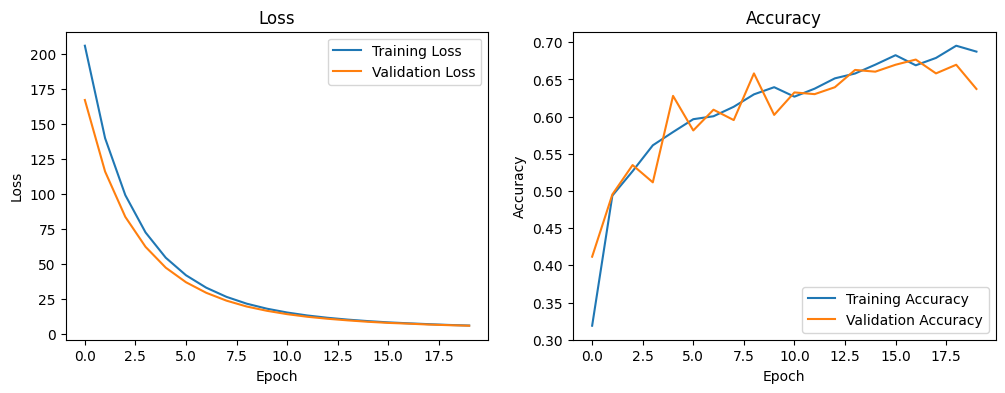

7/7 [==============================] - 72s 10s/step
              precision    recall  f1-score   support

       daisy       0.82      0.61      0.70        76
   dandelion       0.63      0.83      0.71       105
        rose       0.62      0.17      0.26        78
   sunflower       0.77      0.63      0.69        73
       tulip       0.53      0.84      0.65        98

    accuracy                           0.64       430
   macro avg       0.67      0.61      0.60       430
weighted avg       0.66      0.64      0.61       430



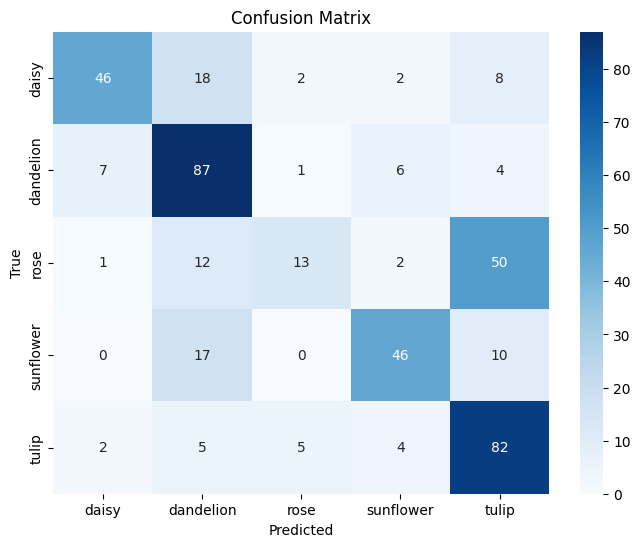

In [ ]:
plot_history(history_base_l2)

y_pred = model_base_l2.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

plot_confusion_matrix(y_true, y_pred)

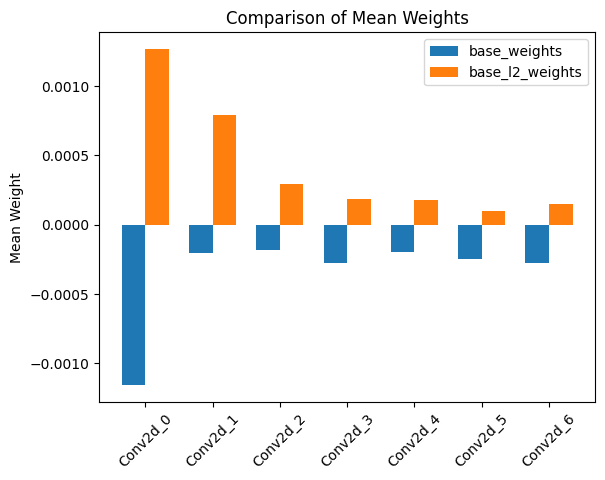

In [ ]:
base_weights = []

for layer in model_base.layers[:10]:
  W = layer.get_weights()
  if len(W) == 0:
    continue
  for idx, w in enumerate(W):
    arr = np.ndarray.flatten(w)
    mean_weight = arr.mean()

    if idx == 0:
        base_weights.append(mean_weight)

base_l2_weights = []

for layer in model_base_l2.layers[:10]:
  W = layer.get_weights()
  if len(W) == 0:
    continue
  for idx, w in enumerate(W):
    arr = np.ndarray.flatten(w)
    mean_weight = arr.mean()

    if idx == 0:
        base_l2_weights.append(mean_weight)

labels = [f'Conv2d_{i}' for i in range(len(base_weights))]

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x, base_weights, width, label='base_weights')
rects2 = ax.bar([i + width for i in x], base_l2_weights, width, label='base_l2_weights')

ax.set_ylabel('Mean Weight')
ax.set_title('Comparison of Mean Weights')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(labels, rotation=45)

ax.legend()
plt.show()


# Base model with Batch normalization

In [ ]:
model_base_bn = Sequential(name='model_base_bn')
model_base_bn.add(Conv2D(64, (3,3), activation='relu', input_shape=(img_width, img_height, 3),padding='same',kernel_initializer='he_normal'))
model_base_bn.add(Conv2D(64, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base_bn.add(BatchNormalization())

model_base_bn.add(MaxPooling2D(pool_size=(2, 2),strides = 2))
model_base_bn.add(Conv2D(128, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base_bn.add(Conv2D(128, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base_bn.add(BatchNormalization())

model_base_bn.add(MaxPooling2D(pool_size=(2, 2),strides = 2))
model_base_bn.add(Conv2D(256, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base_bn.add(Conv2D(256, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base_bn.add(Conv2D(256, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base_bn.add(BatchNormalization())

model_base_bn.add(MaxPooling2D(pool_size=(2, 2),strides = 2))
model_base_bn.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base_bn.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base_bn.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base_bn.add(BatchNormalization())

model_base_bn.add(MaxPooling2D(pool_size=(2, 2),strides = 2))
model_base_bn.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base_bn.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base_bn.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal'))
model_base_bn.add(BatchNormalization())

model_base_bn.add(MaxPooling2D(pool_size=(2, 2),strides = 2))
model_base_bn.add(Flatten())
model_base_bn.add(Dense(4096, activation='relu'))
model_base_bn.add(Dense(4096, activation='relu'))
model_base_bn.add(Dense(5, activation='softmax'))

optimizer = Adam(learning_rate = 1e-4)
model_base_bn.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_base_bn.summary()

Model: "model_base_bn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_5 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 112, 112, 128)   

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_base_bn = model_base_bn.fit(train_generator, epochs=20, validation_data=val_generator, verbose=1, callbacks=[early_stopping])

# Save history
with open('history_base_bn.pkl', 'wb') as file:
    pickle.dump(history_base_bn.history, file)

# Save model
model_base_bn.save('model_base_bn.h5')

In [ ]:
# Load the model
model_base_bn = load_model('model_base_bn.h5')

# Load the history
with open('history_base_bn.pkl', 'rb') as file:
    history_base_bn = pickle.load(file)

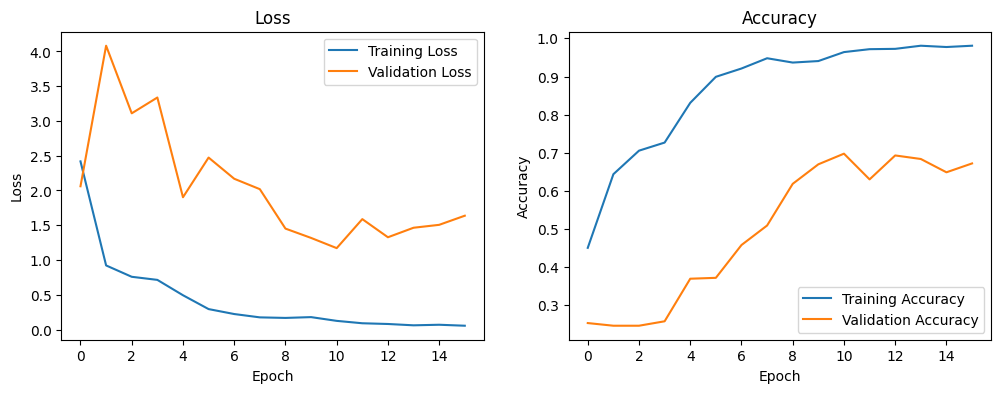

2024-04-14 13:29:53.059498: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 822083584 exceeds 10% of free system memory.
2024-04-14 13:29:53.387028: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 822083584 exceeds 10% of free system memory.
2024-04-14 13:29:54.768484: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 822083584 exceeds 10% of free system memory.


1/7 [===>..........................] - ETA: 1:09

2024-04-14 13:30:04.105051: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 822083584 exceeds 10% of free system memory.
2024-04-14 13:30:04.415616: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 822083584 exceeds 10% of free system memory.


7/7 [==============================] - 70s 10s/step
              precision    recall  f1-score   support

       daisy       0.67      0.72      0.70        76
   dandelion       0.74      0.81      0.77       105
        rose       0.71      0.37      0.49        78
   sunflower       0.80      0.73      0.76        73
       tulip       0.62      0.80      0.70        98

    accuracy                           0.70       430
   macro avg       0.71      0.69      0.68       430
weighted avg       0.70      0.70      0.69       430



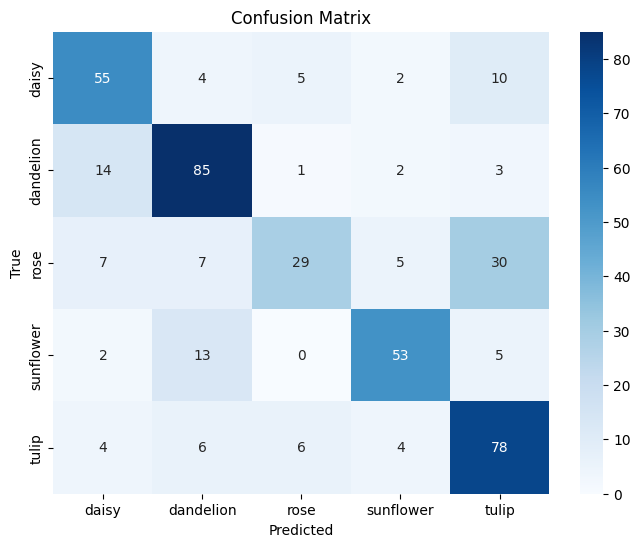

In [ ]:
plot_history(history_base_bn)

y_pred = model_base_bn.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

plot_confusion_matrix(y_true, y_pred)

**7. Improve the accuracy by trying something extra. (20 points)**

Q7.1 By incorporating additional training strategies such as regularization techniques like dropout, data augmentation, and batch or layer normalization, can the accuracy of the model be improved?
* By implementing dropout, data augmentation (rotate, shear, shift, flip), L2, and Batch normalization, Final macro avarage of F1-score improved from 0.67 for base model, 0.60 for base model + L2, and 0.68 for base model + batch norm, to 0.70. However, looking at the train an validation accuracy figure, I found the model still fluctuacted and overfiting. => The only thing should be experiment next is to change the architecture.

Q7.2 Modify the given model architecture to improve the accuracy over the baseline? You can modify the model architecture by adding or removing layers, changing the number of filters, or adding skip connections.
* VGG16 architecture: similar number of parameters (complexity) => The performance is also similar
* VGG16 pretrained with ***imagenet*** dataset: similar number of parameters (complexity), trained to classify 1,000 different classes => Run fast, perform poor => Implement finetuning or feature extraction.

Q7.3 Use transfer learning to fine-tune an existing pre-trained model to improve accuracy?  What approach will you use for transfer learning: feature extraction or fine-tuning and why?
* Well-known images dataset such as ImageNet has 14,197,122 images, which is very large dataset. In our case, we only have over 4000 images, relatively small compare to ImageNet, so that finetuning might not be a good idea(might lead to overfit) => Implement feature extraction instead.

* I tried VGG16, ResNet50, DenseNet121, MobileNetV3Large, MobileNetV2 as feature extractors. DenseNet121 and MobileNetV2 have the best results such that macro avarage of F1-score roughly 0.90.



In [ ]:
train_gen_aug = ImageDataGenerator(
    rescale=(1./255),
    rotation_range=0.4,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

train_generator_aug = train_gen_aug.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch,
    class_mode='sparse',
    shuffle = True
)

Found 3452 images belonging to 5 classes.


# Model with L2, Batch normalization, Dropout

In [ ]:
model_l2_bn_drop = Sequential(name='model_l2_bn_drop')
model_l2_bn_drop.add(Conv2D(64, (3,3), activation='relu', input_shape=(img_height, img_width, 3),padding='same',kernel_initializer='he_normal'))
model_l2_bn_drop.add(Conv2D(64, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_l2_bn_drop.add(BatchNormalization())

model_l2_bn_drop.add(MaxPooling2D(pool_size=(3, 3)))
model_l2_bn_drop.add(Dropout(0.1))
model_l2_bn_drop.add(Conv2D(128, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_l2_bn_drop.add(Conv2D(128, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))

model_l2_bn_drop.add(BatchNormalization())
model_l2_bn_drop.add(MaxPooling2D(pool_size=(3, 3)))
model_l2_bn_drop.add(Dropout(0.1))
model_l2_bn_drop.add(Conv2D(256, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_l2_bn_drop.add(Conv2D(256, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_l2_bn_drop.add(Conv2D(256, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))

model_l2_bn_drop.add(BatchNormalization())
model_l2_bn_drop.add(MaxPooling2D(pool_size=(3, 3)))
model_l2_bn_drop.add(Dropout(0.1))
model_l2_bn_drop.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_l2_bn_drop.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_l2_bn_drop.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))

model_l2_bn_drop.add(BatchNormalization())
model_l2_bn_drop.add(MaxPooling2D(pool_size=(3, 3)))
model_l2_bn_drop.add(Dropout(0.1))
model_l2_bn_drop.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_l2_bn_drop.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_l2_bn_drop.add(Conv2D(512, (3,3), activation='relu',padding='same',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))

model_l2_bn_drop.add(BatchNormalization())
model_l2_bn_drop.add(MaxPooling2D(pool_size=(2, 2)))
model_l2_bn_drop.add(Flatten())
model_l2_bn_drop.add(Dense(4096, activation='relu',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_l2_bn_drop.add(Dense(4096, activation='relu',kernel_initializer='he_normal', kernel_regularizer = l2(0.01)))
model_l2_bn_drop.add(Dense(5, activation='softmax'))

optimizer = Adam(learning_rate = 1e-3)
model_l2_bn_drop.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_l2_bn_drop.summary()

Model: "model_l2_bn_drop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 74, 74, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 74, 74, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 74, 74, 128)  

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_l2_bn_drop = model_l2_bn_drop.fit(train_generator_aug, epochs=30, validation_data = val_generator,verbose = 1,callbacks=[early_stopping])

# Save history
with open('history_l2_bn_drop.pkl', 'wb') as file:
    pickle.dump(history_l2_bn_drop.history, file)

# Save model
model_l2_bn_drop.save('model_l2_bn_drop.h5')

In [ ]:
# Load the model
model_l2_bn_drop = load_model('model_l2_bn_drop.h5')

# Load the history
with open('history_l2_bn_drop.pkl', 'rb') as file:
    history_l2_bn_drop = pickle.load(file)

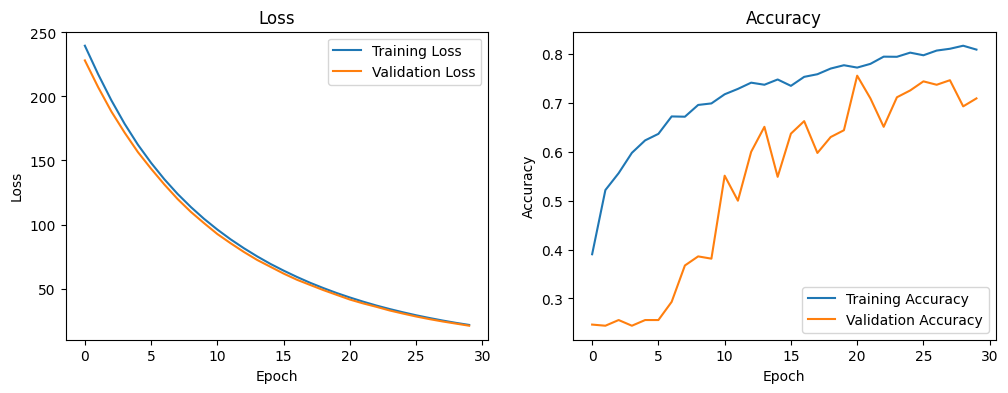

7/7 [==============================] - 26s 4s/step
              precision    recall  f1-score   support

       daisy       0.75      0.76      0.76        76
   dandelion       0.69      0.91      0.79       105
        rose       0.54      0.77      0.63        78
   sunflower       0.86      0.88      0.87        73
       tulip       0.96      0.28      0.43        98

    accuracy                           0.71       430
   macro avg       0.76      0.72      0.70       430
weighted avg       0.77      0.71      0.69       430



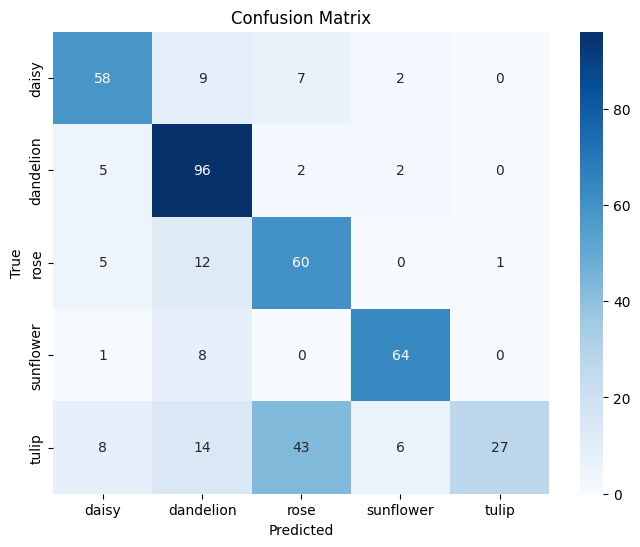

In [ ]:
plot_history(history_l2_bn_drop)

y_pred = model_l2_bn_drop.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

plot_confusion_matrix(y_true, y_pred)

model's macro avg F1-score increase to 0.7, converged after just 5 epochs, smaller in size with 33,623,621, and inference time is faster (26s for validation dataset)

## VGG16 vanilla and train on our dataset

In [ ]:
model_vgg16 = Sequential()
model_vgg16.add(Conv2D(input_shape=(img_height, img_width,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))

model_vgg16.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model_vgg16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model_vgg16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model_vgg16.add(Flatten())
model_vgg16.add(Dense(4096, activation='relu'))
model_vgg16.add(Dense(4096, activation='relu'))
model_vgg16.add(Dense(5, activation='softmax'))

optimizer = Adam(learning_rate = 1e-4)
model_vgg16.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                 

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_vgg16 = model_vgg16.fit(train_generator, epochs=100, validation_data = val_generator, verbose = 1, callbacks=[early_stopping])

# Save history
with open('history_vgg16.pkl', 'wb') as file:
    pickle.dump(history_vgg16.history, file)

# Save model
model_vgg16.save('model_vgg16.h5')

In [ ]:
# Load the model
model_vgg16 = load_model('model_vgg16.h5')

# Load the history
with open('history_vgg16.pkl', 'rb') as file:
    history_vgg16 = pickle.load(file)

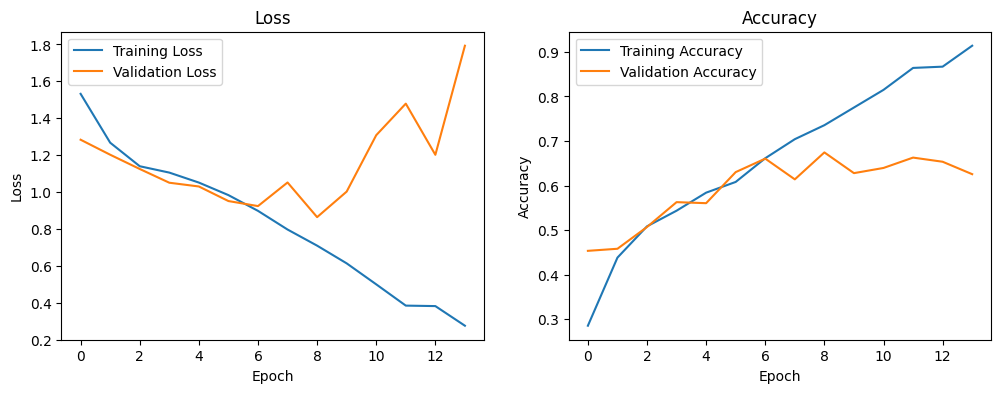

7/7 [==============================] - 68s 10s/step
              precision    recall  f1-score   support

       daisy       0.77      0.63      0.70        76
   dandelion       0.68      0.74      0.71       105
        rose       0.52      0.55      0.53        78
   sunflower       0.82      0.79      0.81        73
       tulip       0.64      0.64      0.64        98

    accuracy                           0.67       430
   macro avg       0.68      0.67      0.68       430
weighted avg       0.68      0.67      0.68       430



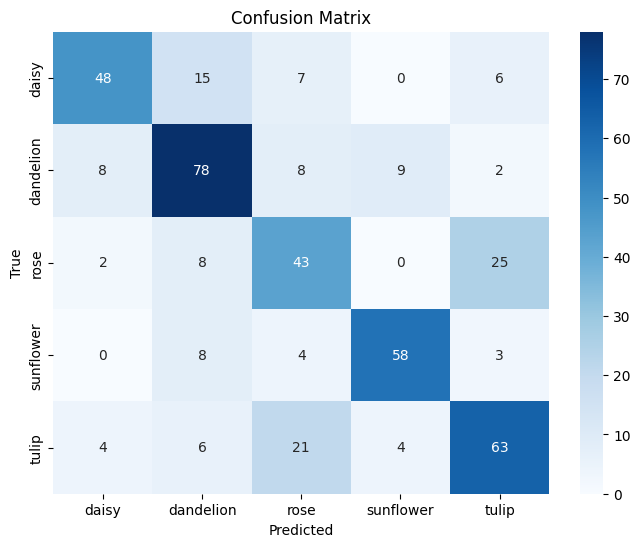

In [ ]:
plot_history(history_vgg16)

y_pred = model_vgg16.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

plot_confusion_matrix(y_true, y_pred)

## VGG16 pretrained with ImageNet

In [ ]:
# Load the VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

7/7 [==============================] - 73s 10s/step
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00        76
   dandelion       0.00      0.00      0.00       105
        rose       0.19      0.99      0.31        78
   sunflower       0.00      0.00      0.00        73
       tulip       0.00      0.00      0.00        98

    accuracy                           0.18       430
   macro avg       0.04      0.20      0.06       430
weighted avg       0.03      0.18      0.06       430



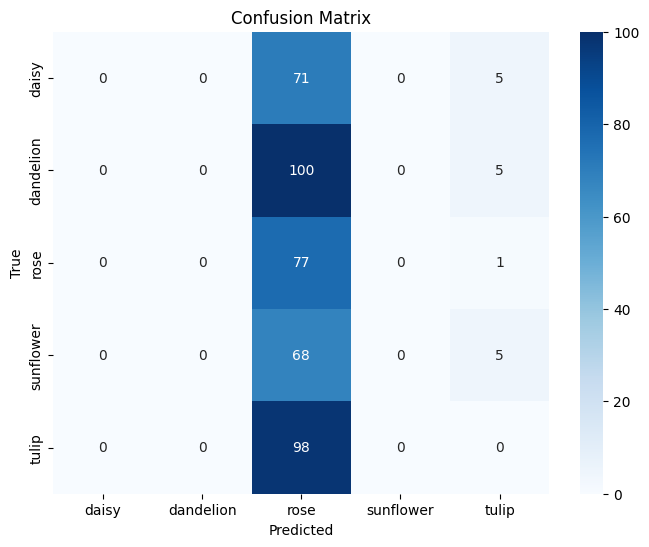

In [ ]:
# Freeze the layers of the VGG16 model
for layer in vgg16.layers:
    layer.trainable = False

# Create a new model by adding a global average pooling layer and a dense output layer
model_vgg16_pretrained = Sequential()
model_vgg16_pretrained.add(vgg16)
model_vgg16_pretrained.add(GlobalAveragePooling2D())
model_vgg16_pretrained.add(Dense(5, activation='softmax'))

y_pred = model_vgg16_pretrained.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

plot_confusion_matrix(y_true, y_pred)


Using pretrained model without finetuning perform poorly => **Feature extraction** and add more layers to classify into 5 classes and train again on those layers

# FEATURE EXTRACTION

In [5]:
macro_f1s = []
extractor_names = []

## Feature extracting using VGG16 

In [ ]:
model_vgg16_fe = Sequential()
model_vgg16_fe.add(vgg16)
model_vgg16_fe.add(GlobalAveragePooling2D())
model_vgg16_fe.add(Dense(5, activation='softmax'))

# Freeze the layers of the VGG16 model
for layer in vgg16.layers:
    layer.trainable = False

# Compile the model
optimizer = Adam(learning_rate=1e-2) # Use a higher learning rate because the model is already trained
model_vgg16_fe.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_vgg16_fe.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 14717253 (56.14 MB)
Trainable params: 2565 (10.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_vgg16_fe = model_vgg16_fe.fit(train_generator, epochs=100, validation_data=val_generator, verbose=1, callbacks=[early_stopping])

In [ ]:
# Save history
with open('history_vgg16_fe.pkl', 'wb') as file:
    pickle.dump(history_vgg16_fe.history, file)

# Save model
model_vgg16_fe.save('model_vgg16_fe.h5')

In [ ]:
# Load the model
model_vgg16_fe = load_model('model_vgg16_fe.h5')

# Load the history
with open('history_vgg16_fe.pkl', 'rb') as file:
    history_vgg16_fe = pickle.load(file)

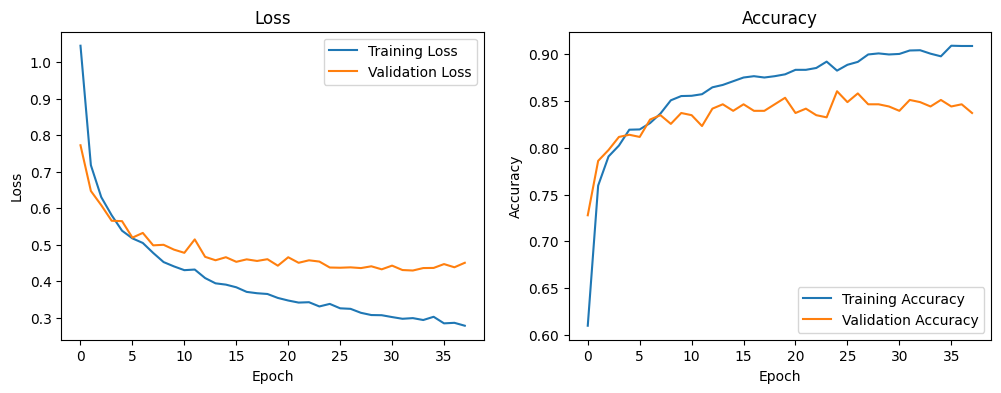

7/7 [==============================] - 73s 10s/step
              precision    recall  f1-score   support

       daisy       0.88      0.80      0.84        76
   dandelion       0.87      0.88      0.87       105
        rose       0.80      0.87      0.83        78
   sunflower       0.82      0.86      0.84        73
       tulip       0.87      0.83      0.85        98

    accuracy                           0.85       430
   macro avg       0.85      0.85      0.85       430
weighted avg       0.85      0.85      0.85       430



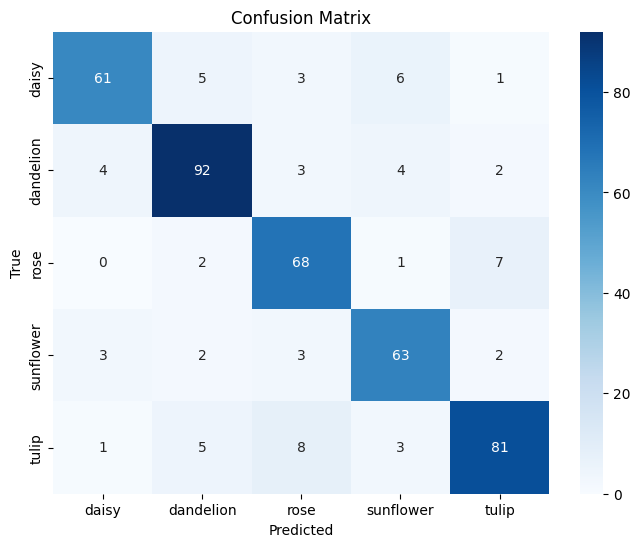

In [ ]:
# Plot the training history
plot_history(history_vgg16_fe)

# Make predictions on the validation set
y_pred = model_vgg16_fe.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred)

In [6]:
# as can be seen above, macro avg = 0.85 
macro_f1s.append(0.85)
extractor_names.append('VGG16')

## Feature extracting using Resnet50


In [ ]:
# Load the Resnet50 model
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the VGG16 model
for layer in resnet50.layers:
    layer.trainable = False


model_resnet50_fe = Sequential()
model_resnet50_fe.add(resnet50)
model_resnet50_fe.add(GlobalAveragePooling2D())
model_resnet50_fe.add(Dense(5, activation='softmax'))

# Freeze the layers of the resnet50 model
for layer in resnet50.layers:
    layer.trainable = False

# Compile the model
optimizer = Adam(learning_rate=1e-2)
model_resnet50_fe.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_resnet50_fe.summary()

94765736/94765736 [==============================] - 14s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_resnet50_fe = model_resnet50_fe.fit(train_generator, epochs=100, validation_data=val_generator, verbose=1, callbacks=[early_stopping])

# Save history
with open('history_resnet50_fe.pkl', 'wb') as file:
    pickle.dump(history_resnet50_fe.history, file)

# Save model
model_resnet50_fe.save('model_resnet50_fe.h5')

In [ ]:
# Load the model
model_resnet50_fe = load_model('model_resnet50_fe.h5')

# Load the history
with open('history_resnet50_fe.pkl', 'rb') as file:
    history_resnet50_fe = pickle.load(file)

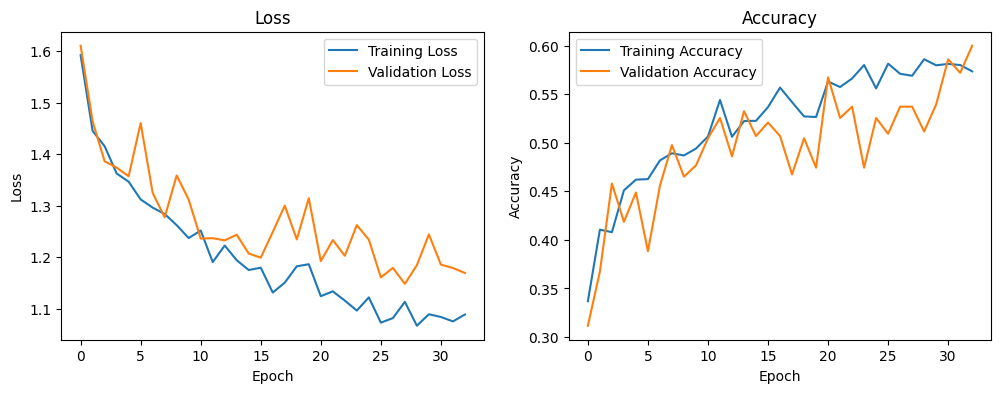

7/7 [==============================] - 41s 6s/step
              precision    recall  f1-score   support

       daisy       0.64      0.58      0.61        76
   dandelion       0.49      0.69      0.57       105
        rose       0.43      0.46      0.44        78
   sunflower       0.65      0.45      0.53        73
       tulip       0.62      0.49      0.55        98

    accuracy                           0.54       430
   macro avg       0.56      0.53      0.54       430
weighted avg       0.56      0.54      0.54       430



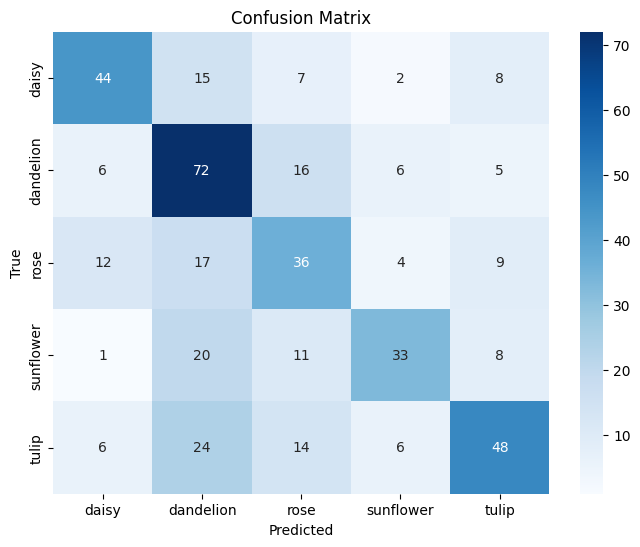

In [ ]:
# Plot the training history
plot_history(history_resnet50_fe)

# Make predictions on the validation set
y_pred = model_resnet50_fe.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred)


In [7]:
macro_f1s.append(0.54)
extractor_names.append('ResNet50')

## Feature extracting using DenseNet121

In [ ]:
# Load the densenet121 model
densenet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the VGG16 model
for layer in densenet121.layers:
    layer.trainable = False


model_densenet121_fe = Sequential()
model_densenet121_fe.add(densenet121)
model_densenet121_fe.add(GlobalAveragePooling2D())
model_densenet121_fe.add(Dense(5, activation='softmax'))

# Freeze the layers of the densenet121 model
for layer in densenet121.layers:
    layer.trainable = False

# Compile the model
optimizer = Adam(learning_rate=1e-3)
model_densenet121_fe.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_densenet121_fe.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_densenet121_fe = model_densenet121_fe.fit(train_generator, epochs=100, validation_data=val_generator, verbose=1, callbacks=[early_stopping])

# Save history
with open('history_densenet121_fe.pkl', 'wb') as file:
    pickle.dump(history_densenet121_fe.history, file)

# Save model
model_densenet121_fe.save('model_densenet121_fe.h5')

In [ ]:
# Load the model
model_densenet121_fe = load_model('model_densenet121_fe.h5')

# Load the history
with open('history_densenet121_fe.pkl', 'rb') as file:
    history_densenet121_fe = pickle.load(file)

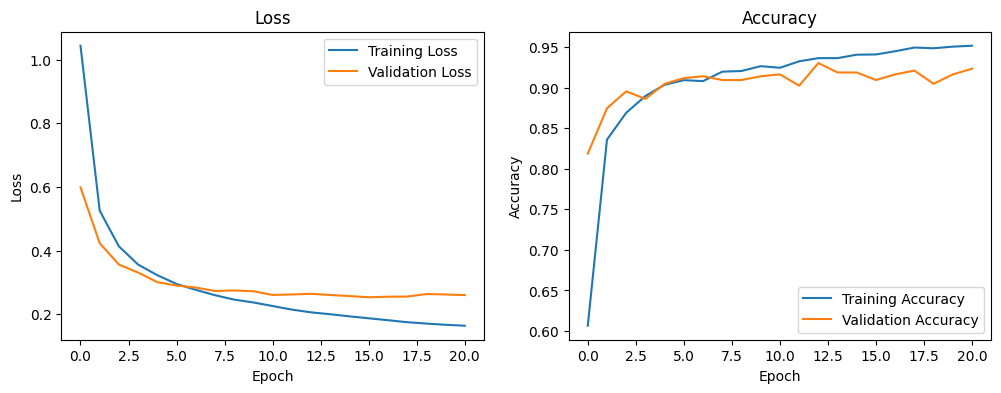

7/7 [==============================] - 43s 6s/step
              precision    recall  f1-score   support

       daisy       0.95      0.93      0.94        76
   dandelion       0.92      0.93      0.93       105
        rose       0.88      0.85      0.86        78
   sunflower       0.91      0.93      0.92        73
       tulip       0.89      0.90      0.89        98

    accuracy                           0.91       430
   macro avg       0.91      0.91      0.91       430
weighted avg       0.91      0.91      0.91       430



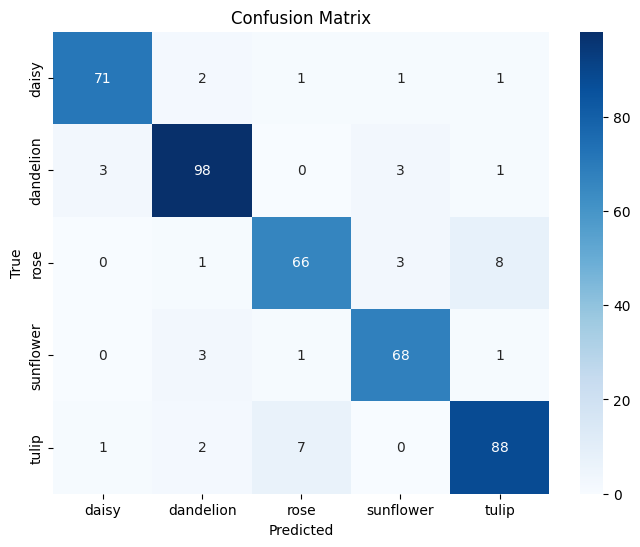

In [ ]:
# Plot the training history
plot_history(history_densenet121_fe)

# Make predictions on the validation set
y_pred = model_densenet121_fe.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred)

In [8]:
macro_f1s.append(0.91)
extractor_names.append('DenseNet121')

## Feature extracting using InceptionV3


In [ ]:
# Load the inceptionv3 model
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the VGG16 model
for layer in inceptionv3.layers:
    layer.trainable = False


model_inceptionv3_fe = Sequential()
model_inceptionv3_fe.add(inceptionv3)
model_inceptionv3_fe.add(GlobalAveragePooling2D())
model_inceptionv3_fe.add(Dense(5, activation='softmax'))

# Freeze the layers of the inceptionv3 model
for layer in inceptionv3.layers:
    layer.trainable = False

# Compile the model
optimizer = Adam(learning_rate=1e-3)
model_inceptionv3_fe.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_inceptionv3_fe.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_inceptionv3_fe = model_inceptionv3_fe.fit(train_generator, epochs=100, validation_data=val_generator, verbose=1, callbacks=[early_stopping])

# Save history
with open('history_inceptionv3_fe.pkl', 'wb') as file:
    pickle.dump(history_inceptionv3_fe.history, file)

# Save model
model_inceptionv3_fe.save('model_inceptionv3_fe.h5')

In [ ]:
# Load the model
model_inceptionv3_fe = load_model('model_inceptionv3_fe.h5')

# Load the history
with open('history_inceptionv3_fe.pkl', 'rb') as file:
    history_inceptionv3_fe = pickle.load(file)

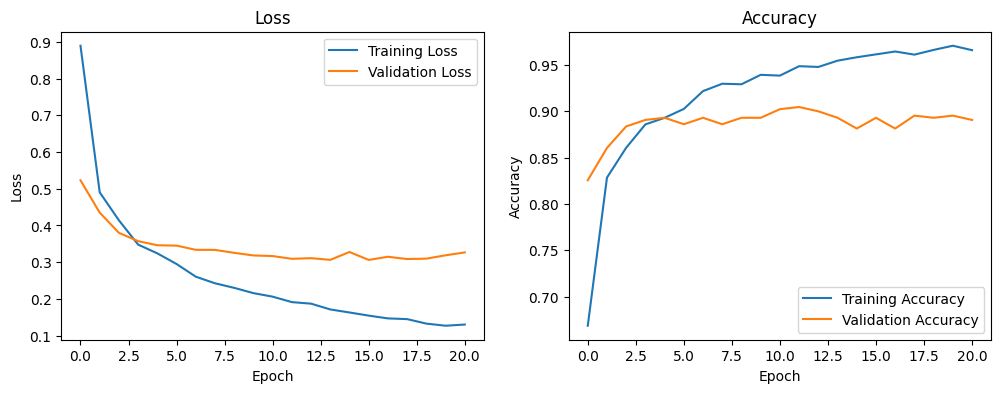

7/7 [==============================] - 19s 3s/step
              precision    recall  f1-score   support

       daisy       0.91      0.92      0.92        76
   dandelion       0.93      0.94      0.93       105
        rose       0.83      0.88      0.86        78
   sunflower       0.90      0.84      0.87        73
       tulip       0.89      0.87      0.88        98

    accuracy                           0.89       430
   macro avg       0.89      0.89      0.89       430
weighted avg       0.89      0.89      0.89       430



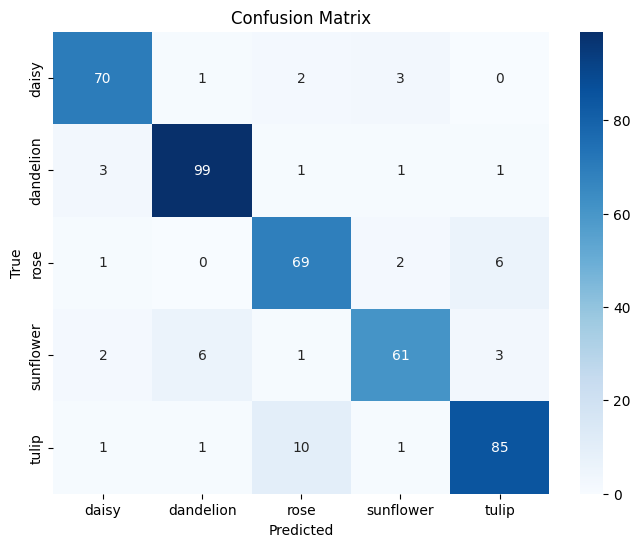

In [ ]:
# Plot the training history
plot_history(history_inceptionv3_fe)

# Make predictions on the validation set
y_pred = model_inceptionv3_fe.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred)

In [ ]:
macro_f1s.append(0.89)
extractor_names.append('InceptionV3')

## Feature extracting using MobileNetV3Large


In [ ]:
# Load the mobilenetv3_large model
mobilenetv3_large = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the VGG16 model
for layer in mobilenetv3_large.layers:
    layer.trainable = False


model_mobilenetv3_large_fe = Sequential()
model_mobilenetv3_large_fe.add(mobilenetv3_large)
model_mobilenetv3_large_fe.add(GlobalAveragePooling2D())
model_mobilenetv3_large_fe.add(Dense(5, activation='softmax'))

# Freeze the layers of the mobilenetv3_large model
for layer in mobilenetv3_large.layers:
    layer.trainable = False

# Compile the model
optimizer = Adam(learning_rate=1e-3)
model_mobilenetv3_large_fe.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_mobilenetv3_large_fe.summary()

12683000/12683000 [==============================] - 2s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_3  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 5)                 4805      
                                                                 
Total params: 3001157 (11.45 MB)
Trainable params: 4805 (18.77 KB)
Non-trainable params: 2996352 (11.43 MB)
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_mobilenetv3_large_fe = model_mobilenetv3_large_fe.fit(train_generator, epochs=100, validation_data=val_generator, verbose=1, callbacks=[early_stopping])

# Save history
with open('history_mobilenetv3_large_fe.pkl', 'wb') as file:
    pickle.dump(history_mobilenetv3_large_fe.history, file)

# Save model
model_mobilenetv3_large_fe.save('model_mobilenetv3_large_fe.h5')


In [ ]:
# Load the model
model_mobilenetv3_large_fe = load_model('model_mobilenetv3_large_fe.h5')

# Load the history
with open('history_mobilenetv3_large_fe.pkl', 'rb') as file:
    history_mobilenetv3_large_fe = pickle.load(file)

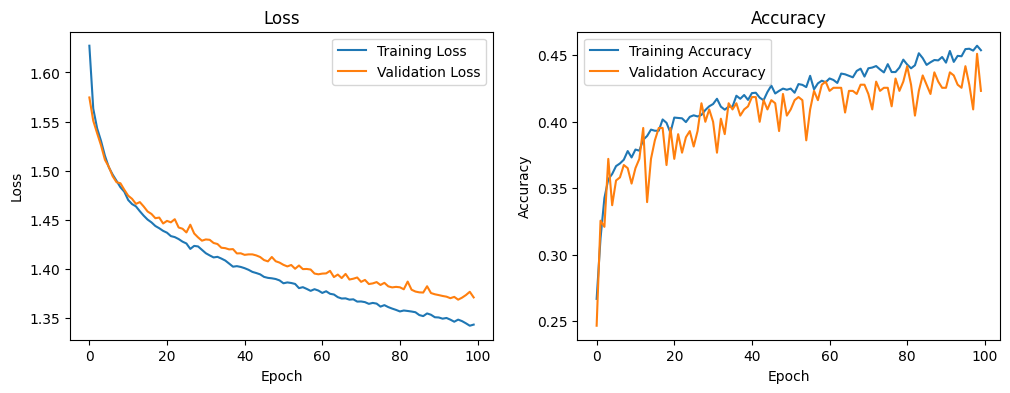

7/7 [==============================] - 12s 2s/step
              precision    recall  f1-score   support

       daisy       0.60      0.38      0.47        76
   dandelion       0.43      0.69      0.53       105
        rose       0.37      0.27      0.31        78
   sunflower       0.38      0.22      0.28        73
       tulip       0.38      0.45      0.41        98

    accuracy                           0.42       430
   macro avg       0.43      0.40      0.40       430
weighted avg       0.43      0.42      0.41       430



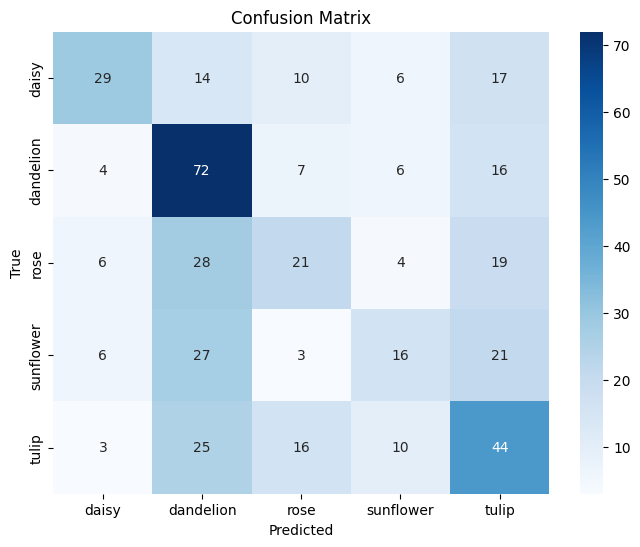

In [ ]:
# Plot the training history
plot_history(history_mobilenetv3_large_fe)

# Make predictions on the validation set
y_pred = model_mobilenetv3_large_fe.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred)

In [9]:
macro_f1s.append(0.40)
extractor_names.append('MobileNetV3Large')

## Feature extracting using MobileNetV2 

In [ ]:
# Load the mobilenetv2 model
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the VGG16 model
for layer in mobilenetv2.layers:
    layer.trainable = False


model_mobilenetv2_fe = Sequential()
model_mobilenetv2_fe.add(mobilenetv2)
model_mobilenetv2_fe.add(GlobalAveragePooling2D())
model_mobilenetv2_fe.add(Dense(5, activation='softmax'))

# Freeze the layers of the mobilenetv2 model
for layer in mobilenetv2.layers:
    layer.trainable = False

# Compile the model
optimizer = Adam(learning_rate=1e-3)
model_mobilenetv2_fe.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_mobilenetv2_fe.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_mobilenetv2_fe = model_mobilenetv2_fe.fit(train_generator, epochs=100, validation_data=val_generator, verbose=1, callbacks=[early_stopping])

# Save history
with open('history_mobilenetv2_fe.pkl', 'wb') as file:
    pickle.dump(history_mobilenetv2_fe.history, file)

# Save model
model_mobilenetv2_fe.save('model_mobilenetv2_fe.h5')

In [ ]:
# Load the model
model_mobilenetv2_fe = load_model('model_mobilenetv2_fe.h5')

# Load the history
with open('history_mobilenetv2_fe.pkl', 'rb') as file:
    history_mobilenetv2_fe = pickle.load(file)

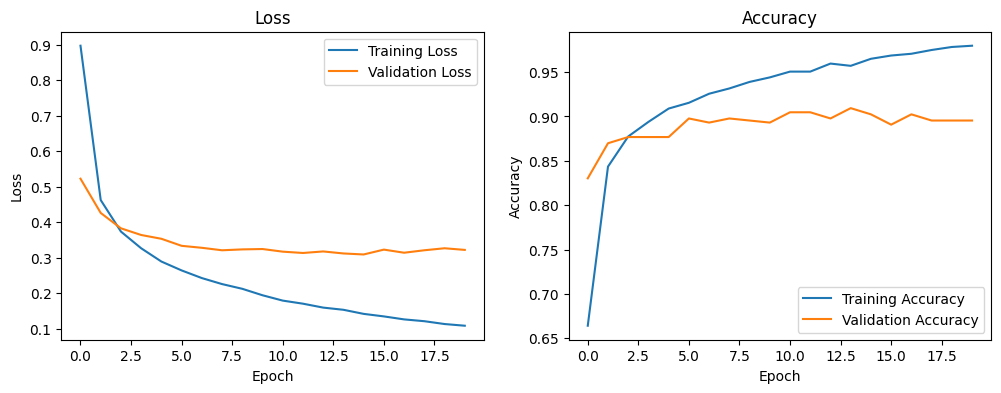

7/7 [==============================] - 12s 2s/step
              precision    recall  f1-score   support

       daisy       0.91      0.89      0.90        76
   dandelion       0.95      0.95      0.95       105
        rose       0.84      0.83      0.84        78
   sunflower       0.96      0.95      0.95        73
       tulip       0.85      0.88      0.86        98

    accuracy                           0.90       430
   macro avg       0.90      0.90      0.90       430
weighted avg       0.90      0.90      0.90       430



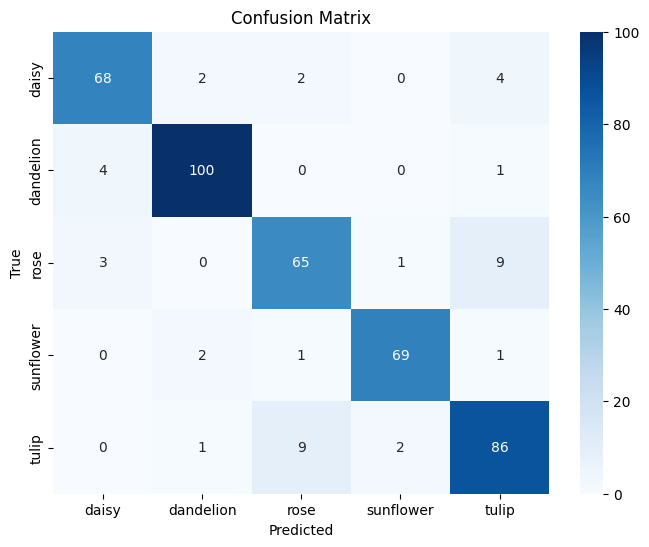

In [ ]:
# Plot the training history
plot_history(history_mobilenetv2_fe)

# Make predictions on the validation set
y_pred = model_mobilenetv2_fe.predict(val_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred)

In [12]:
macro_f1s.append(0.90)
extractor_names.append('MobileNetV2')

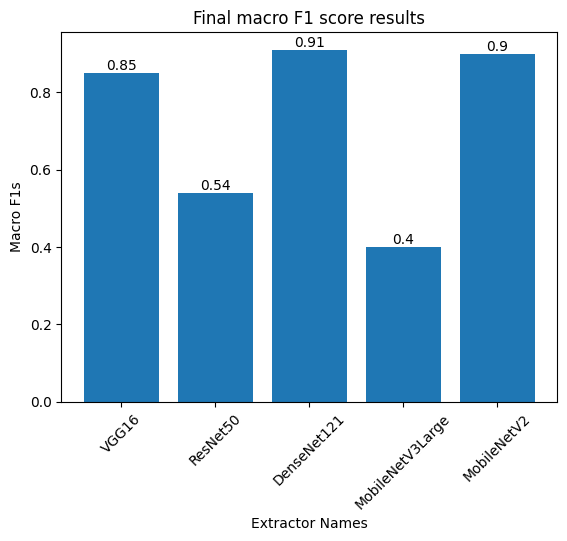

In [14]:
plt.bar(extractor_names, macro_f1s)
plt.xlabel('Extractor Names')
plt.ylabel('Macro F1s')
plt.xticks(rotation=45)  # Rotate x-labels by 45 degrees
for i, v in enumerate(macro_f1s):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.title('Final macro F1 score results')
plt.show()


Reference: 
1. Kull, M, Perello-Nieto, M, Kängsepp, M, Filho, T, Song, H & Flach, P n.d., Beyond temperature scaling: Obtaining well-calibrated multiclass probabilities with Dirichlet calibration, viewed 15 April 2024, <https://arxiv.org/pdf/1910.12656.pdf>.
‌